### Step 1: Import Libraries

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from helper import preprocess, load_data, save_trained_model

### Step 2: Load and Preprocess  Data

In [17]:
# Load Data
df, test_df = load_data("/mnt/survey1.csv")
df.to_csv("/mnt/test_data.csv", index=False)
test_df.to_csv("/mnt/test_data_test.csv", index=False)

# Preprocess data
X, feature_names, scaler, category_maps = preprocess(df, return_state=True)

### Step 3: Perform Agglomerative Clustering

In [18]:
# Perform agglomerative clustering
agg_clustering = AgglomerativeClustering(n_clusters=3)
y_pred = agg_clustering.fit_predict(X)
print(y_pred)

# Save trained model
save_trained_model(agg_clustering, "/mnt/agg_clustering.joblib")

[0 1 1 0 1 1 0 2 1 1 1]


### Step 4: Plot the Clusters

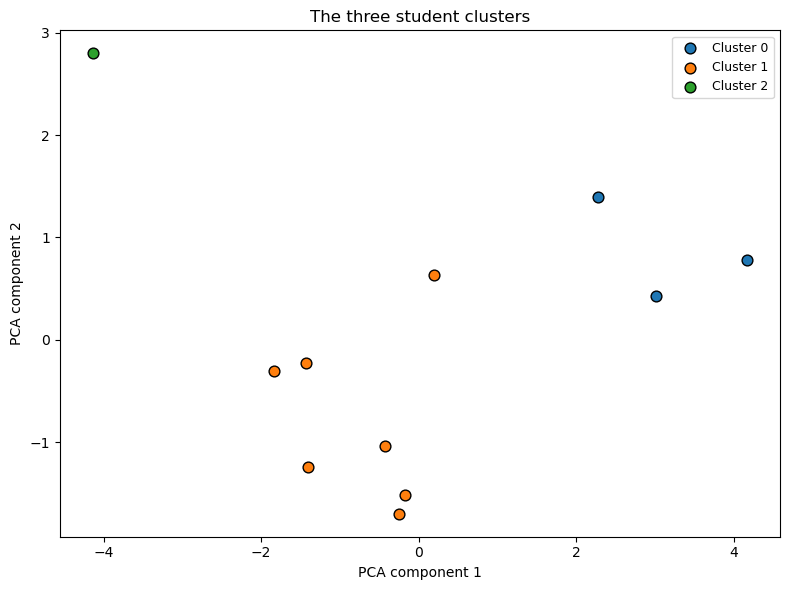

In [19]:
from sklearn.decomposition import PCA
X_2d = PCA(n_components=2).fit_transform(X)

# Get cluster IDs and colors
cluster_ids = np.unique(y_pred)
tab10_colors = plt.colormaps['tab10'].colors

# Plot the clusters
plt.figure(figsize=(8, 6))

# Plot each cluster with explicit color assignment
for idx, cluster_id in enumerate(cluster_ids):
    mask = y_pred == cluster_id
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1], 
                c=[tab10_colors[idx]], 
                s=60, 
                edgecolors='k',
                label=f'Cluster {cluster_id}')

plt.title("The three student clusters")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.legend(loc='best', fontsize=9)
plt.tight_layout()
plt.show()

In [20]:
# How Each component contributed to PCA (Optional)
pca = PCA(n_components=2).fit(X)
X_2d = pca.transform(X)
print("Component weights:")
print(pca.components_)        # shape (2, n_features)
print("Explained variance ratio:", pca.explained_variance_ratio_)

Component weights:
[[ 0.40099974  0.39233773  0.37583826  0.02381938  0.41954519  0.38881314
   0.29256141  0.30664386  0.19139514]
 [ 0.15599976  0.00879379  0.3082324   0.56263083  0.04118499  0.23171722
  -0.46540227 -0.24095615 -0.48371259]]
Explained variance ratio: [0.57087252 0.19147219]


### Step 5: Plot the Dendrogram
For Model Evaluation

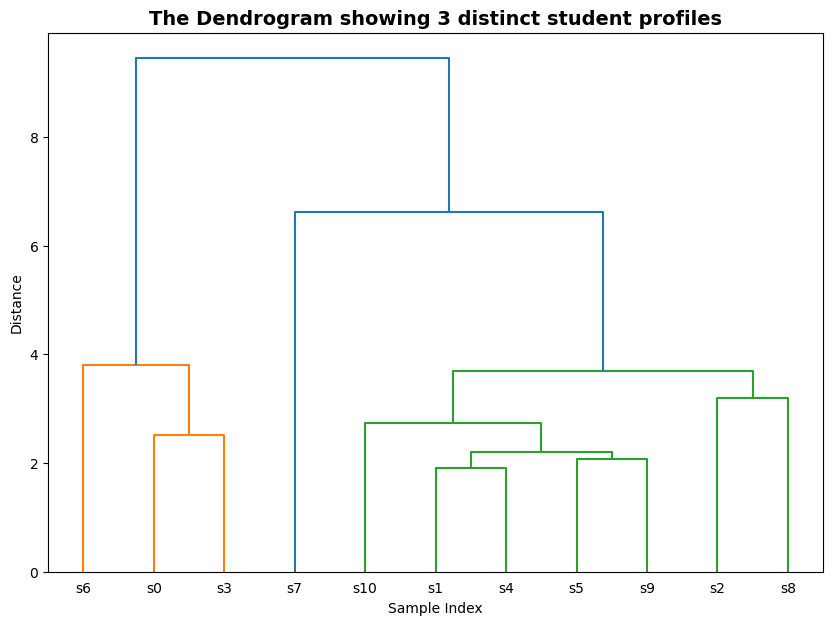

In [21]:
# Generate the linkage matrix
Z = linkage(X, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=[f"s{i}" for i in range(len(X))], leaf_font_size=10)
plt.title('The Dendrogram showing 3 distinct student profiles', fontweight='bold', fontsize=14)
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

### Step 6: Model Evaluation and Hyperparameter Tuning To Determine Optimal Number of Clusters

We'll test different values of n_clusters and evaluate them using three metrics:
- **Silhouette Score**: Measures how similar points are to their own cluster vs. other clusters (higher is better, range: -1 to 1)
- **Davies-Bouldin Index**: Measures cluster compactness and separation (lower is better, range: 0 to ∞)
- **Calinski-Harabasz Index**: Ratio of between-cluster to within-cluster variance (higher is better, range: 0 to ∞)

In [22]:
# Import evaluation metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

# Test different numbers of clusters
cluster_range = range(2, 8)  # Test from 2 to 7 clusters
silhouette_scores = []
db_scores = []
ch_scores = []

for n in cluster_range:
    agg = AgglomerativeClustering(n_clusters=n)
    labels = agg.fit_predict(X)
    
    silhouette_scores.append(silhouette_score(X, labels))
    db_scores.append(davies_bouldin_score(X, labels))
    ch_scores.append(calinski_harabasz_score(X, labels))
    
    print(labels)

print("Evaluation complete for n_clusters from 2 to 7")

[1 0 0 1 0 0 1 0 0 0 0]
[0 1 1 0 1 1 0 2 1 1 1]
[1 0 0 1 0 0 3 2 0 0 0]
[4 1 0 4 1 1 3 2 0 1 1]
[1 0 5 1 0 0 3 2 4 0 0]
[0 1 5 0 1 1 3 6 4 1 2]
Evaluation complete for n_clusters from 2 to 7


### 6.1 Visualize Metrics to Find Optimal n_clusters

Look for:
- **Silhouette**: Highest peak
- **Davies-Bouldin**: Lowest valley
- **Calinski-Harabasz**: Highest peak or elbow point

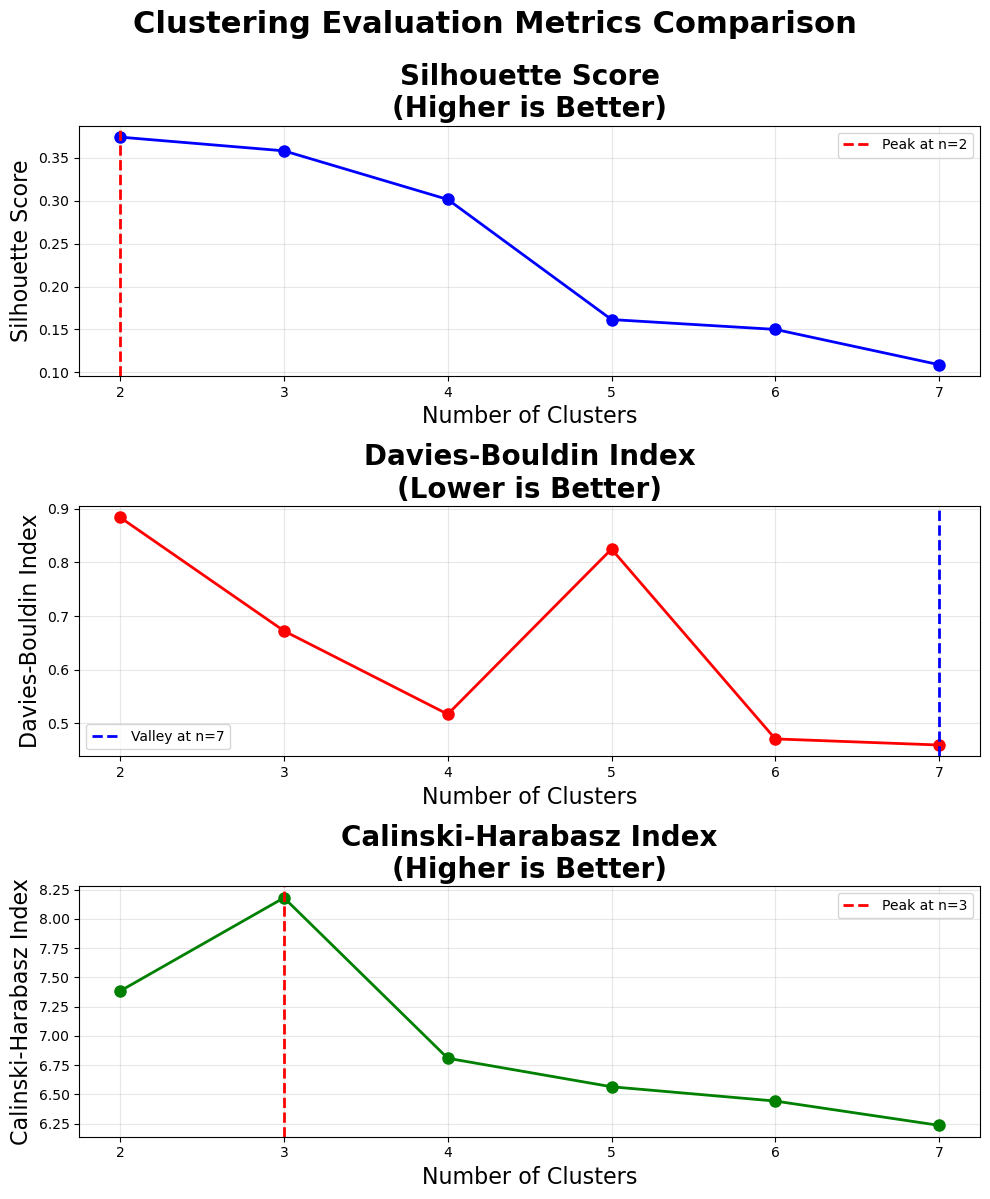

In [23]:
# Plot all three metrics vertically
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Add a main title for the entire figure
fig.suptitle('Clustering Evaluation Metrics Comparison', fontsize=22, fontweight='bold', y=0.995)

# Silhouette Score - look for peak
axes[0].plot(cluster_range, silhouette_scores, marker='o', color='blue', linewidth=2, markersize=8)
axes[0].axvline(x=cluster_range[np.argmax(silhouette_scores)], color='red', linestyle='--', 
                linewidth=2, label=f'Peak at n={cluster_range[np.argmax(silhouette_scores)]}')
axes[0].set_xlabel('Number of Clusters', fontsize=16)
axes[0].set_ylabel('Silhouette Score', fontsize=16)
axes[0].set_title('Silhouette Score\n(Higher is Better)', fontsize=20, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(cluster_range)

# Davies-Bouldin - look for valley (minimum)
axes[1].plot(cluster_range, db_scores, marker='o', color='red', linewidth=2, markersize=8)
axes[1].axvline(x=cluster_range[np.argmin(db_scores)], color='blue', linestyle='--', 
                linewidth=2, label=f'Valley at n={cluster_range[np.argmin(db_scores)]}')
axes[1].set_xlabel('Number of Clusters', fontsize=16)
axes[1].set_ylabel('Davies-Bouldin Index', fontsize=16)
axes[1].set_title('Davies-Bouldin Index\n(Lower is Better)', fontsize=20, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(cluster_range)

# Calinski-Harabasz - look for peak/elbow
axes[2].plot(cluster_range, ch_scores, marker='o', color='green', linewidth=2, markersize=8)
axes[2].axvline(x=cluster_range[np.argmax(ch_scores)], color='red', linestyle='--', 
                linewidth=2, label=f'Peak at n={cluster_range[np.argmax(ch_scores)]}')
axes[2].set_xlabel('Number of Clusters', fontsize=16)
axes[2].set_ylabel('Calinski-Harabasz Index', fontsize=16)
axes[2].set_title('Calinski-Harabasz Index\n(Higher is Better)', fontsize=20, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(cluster_range)

plt.tight_layout()
plt.show()

### 6.2 Individual Metric Recommendations

Each metric suggests an optimal value based on its criteria.

**Interpretation Guidelines:**
- **Silhouette Score**: > 0.7 (excellent), > 0.5 (good), > 0.25 (fair)
- **Davies-Bouldin**: < 1.0 (good), < 2.0 (acceptable)
- **Calinski-Harabasz**: Compare relative values; higher is better

In [24]:
# Print recommendations from each metric
print("=" * 60)
print("OPTIMAL n_clusters BY EACH METRIC")
print("=" * 60)

optimal_silhouette = cluster_range[np.argmax(silhouette_scores)]
optimal_db = cluster_range[np.argmin(db_scores)]
optimal_ch = cluster_range[np.argmax(ch_scores)]

print(f"\n1. Silhouette Score")
print(f"   Optimal: n_clusters = {optimal_silhouette}")
print(f"   Score: {max(silhouette_scores):.4f}")
print(f"   Interpretation: {'Excellent' if max(silhouette_scores) > 0.7 else 'Good' if max(silhouette_scores) > 0.5 else 'Fair'}")

print(f"\n2. Davies-Bouldin Index")
print(f"   Optimal: n_clusters = {optimal_db}")
print(f"   Score: {min(db_scores):.4f}")
print(f"   Interpretation: {'Good' if min(db_scores) < 1.0 else 'Fair'}")

print(f"\n3. Calinski-Harabasz Index")
print(f"   Optimal: n_clusters = {optimal_ch}")
print(f"   Score: {max(ch_scores):.2f}")
print(f"   Interpretation: Higher values indicate better defined clusters")

OPTIMAL n_clusters BY EACH METRIC

1. Silhouette Score
   Optimal: n_clusters = 2
   Score: 0.3740
   Interpretation: Fair

2. Davies-Bouldin Index
   Optimal: n_clusters = 7
   Score: 0.4598
   Interpretation: Good

3. Calinski-Harabasz Index
   Optimal: n_clusters = 3
   Score: 8.18
   Interpretation: Higher values indicate better defined clusters


### 6.3 Detailed Comparison Table

Rank all tested cluster numbers from best to worst to select the optimum n_clusters value since there was no aggreement between the Silhouette score, Davies-Bouldin index and Calinski-Harabasz index

In [25]:
# Create detailed comparison table
from sklearn.preprocessing import MinMaxScaler

results_df = pd.DataFrame(
    {
        "n_clusters": list(cluster_range),
        "Silhouette": silhouette_scores,
        "Davies_Bouldin": db_scores,
        "Calinski_Harabasz": ch_scores,
    }
)

# Add rankings (1 = best, higher = worse)
results_df["Silhouette_Rank"] = (
    results_df["Silhouette"].rank(ascending=False).astype(int)
)
results_df["DB_Rank"] = (
    results_df["Davies_Bouldin"].rank(ascending=True).astype(int)
)  # Lower is better
results_df["CH_Rank"] = (
    results_df["Calinski_Harabasz"].rank(ascending=False).astype(int)
)

# Average rank (lower is better)
results_df["Avg_Rank"] = results_df[["Silhouette_Rank", "DB_Rank", "CH_Rank"]].mean(
    axis=1
)

# Rank models (normalize scores for comparison)
# Normalize scores (all to 0-1, higher is better)
results_df["silhouette_norm"] = (
    MinMaxScaler().fit_transform(results_df[["Silhouette"]]).flatten()
)
results_df["davies_bouldin_norm"] = (
    1 - MinMaxScaler().fit_transform(results_df[["Davies_Bouldin"]])
).flatten()  # Invert
results_df["calinski_norm"] = (
    MinMaxScaler().fit_transform(results_df[["Calinski_Harabasz"]]).flatten()
)

# Combined score (average of normalized metrics)
results_df["combined_score"] = results_df[
    ["silhouette_norm", "davies_bouldin_norm", "calinski_norm"]
].mean(axis=1)

# Sort by BOTH Avg_Rank (primary) and combined_score (secondary/tie-breaker)
results_df_sorted = results_df.sort_values(
    by=["Avg_Rank", "combined_score"], 
    ascending=[True, False]  # Avg_Rank: lower is better, combined_score: higher is better
).reset_index(drop=True)
results_df_sorted.index = results_df_sorted.index + 1  # Start index at 1

# Select columns to display (excluding normalized columns)
columns_to_display = [
    "n_clusters",
    "Silhouette",
    "Davies_Bouldin",
    "Calinski_Harabasz",
    "Silhouette_Rank",
    "DB_Rank",
    "CH_Rank",
    "Avg_Rank",
    "combined_score",
]

print("DETAILED RANKING TABLE (Best to Worst)")
print("=" * 120)
print(results_df_sorted[columns_to_display].to_string())
print("\n" + "=" * 120)
print(f"🏆 BEST by Average Rank and Combined Score: n_clusters = {int(results_df_sorted.iloc[0]['n_clusters'])}")
print(f"   Average Rank: {results_df_sorted.iloc[0]['Avg_Rank']:.2f}")
print(f"   Combined Score: {results_df_sorted.iloc[0]['combined_score']:.4f}")

DETAILED RANKING TABLE (Best to Worst)
   n_clusters  Silhouette  Davies_Bouldin  Calinski_Harabasz  Silhouette_Rank  DB_Rank  CH_Rank  Avg_Rank  combined_score
1           3    0.358059        0.672319           8.180321                2        4        1  2.333333        0.812757
2           4    0.301431        0.517124           6.808589                3        3        3  3.000000        0.628513
3           2    0.374038        0.883624           7.383787                1        6        2  3.000000        0.530159
4           6    0.150079        0.471151           6.442868                5        2        5  4.000000        0.411649
5           7    0.108987        0.459788           6.235290                6        1        6  4.333333        0.333333
6           5    0.161539        0.824710           6.565089                4        5        4  4.333333        0.168945

🏆 BEST by Average Rank and Combined Score: n_clusters = 3
   Average Rank: 2.33
   Combined Score: 0.8128


### Step 7: Predict for test data

In [26]:
# Predict cluster assignments for the held-out test_df
if test_df.empty:
    print("test_df is empty; no predictions generated.")
else:
    from scipy.spatial.distance import cdist

    # Transform test features using the training preprocessing pipeline
    X_test, _ = preprocess(test_df, scaler=scaler, category_maps=category_maps)
    # Compute centroids from training clusters
    n_clusters = len(np.unique(y_pred))
    train_centroids = np.array([X[y_pred == i].mean(axis=0) for i in range(n_clusters)])

    # Assign test points to nearest training centroid
    distances = cdist(X_test, train_centroids, metric="euclidean")
    test_cluster_labels = np.argmin(distances, axis=1)
print("Predicted test cluster labels:", test_cluster_labels)


Predicted test cluster labels: [1 1 1 1 1]


### Step 8: Plot Predicted data

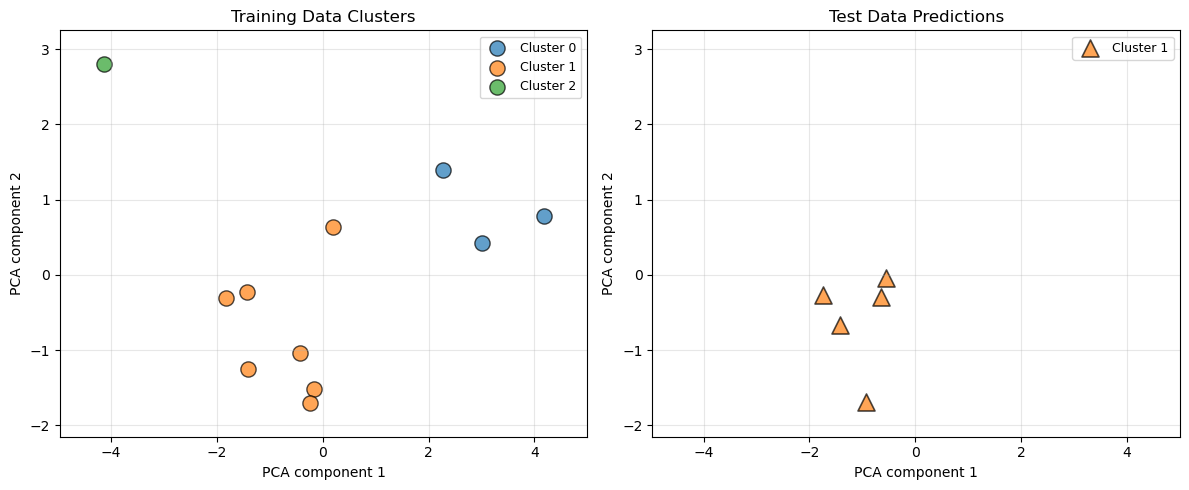

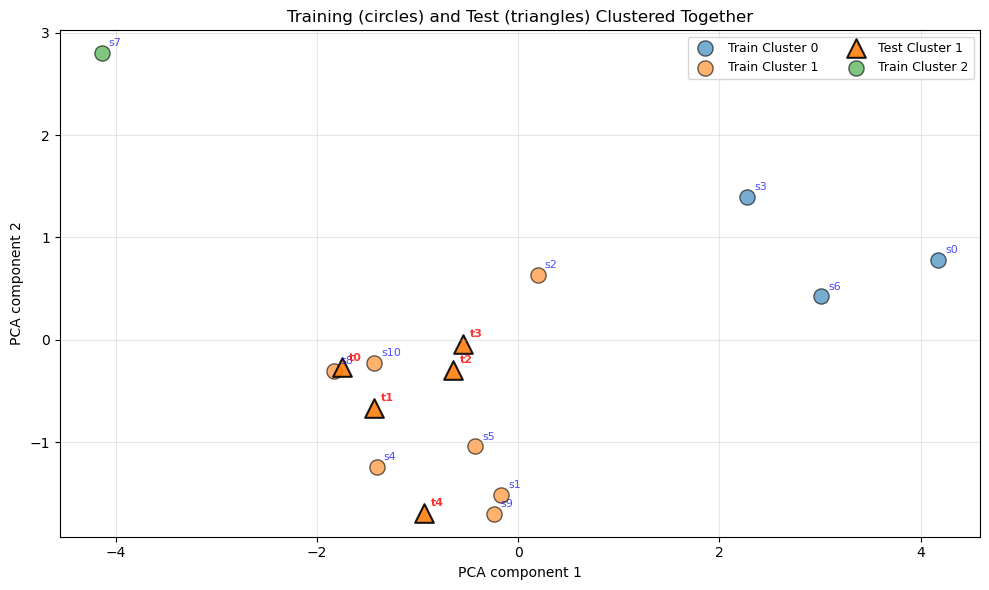

In [27]:
# Plot training and test projections side-by-side in the same PCA space
if test_df.empty:
    print("test_df is empty; skipping prediction plot.")
else:
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Ensure test features are available; recompute if the prediction cell was skipped
    if 'X_test' not in locals():
        X_test, _ = preprocess(test_df, scaler=scaler, category_maps=category_maps)
    if 'test_cluster_labels' not in locals():
        raise RuntimeError("Run the prediction cell first to obtain test_cluster_labels.")
    
    # Fit PCA on the training dataset for a shared projection
    pca_combined = PCA(n_components=2).fit(X)  # Only fit on training data
    train_proj = pca_combined.transform(X)
    test_proj = pca_combined.transform(X_test)  # Transform test using training PCA
    
    cluster_ids = np.unique(y_pred)
    tab10_colors = plt.colormaps['tab10'].colors
    
    # Get combined axis limits for consistent scaling
    all_x = np.concatenate([train_proj[:, 0], test_proj[:, 0]])
    all_y = np.concatenate([train_proj[:, 1], test_proj[:, 1]])
    x_margin = (all_x.max() - all_x.min()) * 0.1
    y_margin = (all_y.max() - all_y.min()) * 0.1
    xlims = [all_x.min() - x_margin, all_x.max() + x_margin]
    ylims = [all_y.min() - y_margin, all_y.max() + y_margin]
    
    plt.figure(figsize=(12, 5))
    
    # Subplot 1: Training data only
    plt.subplot(1, 2, 1)
    for idx, cluster_id in enumerate(cluster_ids):
        mask = y_pred == cluster_id
        plt.scatter(
            train_proj[mask, 0],
            train_proj[mask, 1],
            s=120,
            color=tab10_colors[idx],
            edgecolors='k',
            alpha=0.7,
            label=f'Cluster {cluster_id}'
        )
    plt.title('Training Data Clusters')
    plt.xlabel('PCA component 1')
    plt.ylabel('PCA component 2')
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.legend(loc='best', fontsize=9)
    plt.grid(alpha=0.3)
    
    # Subplot 2: Test data predictions
    plt.subplot(1, 2, 2)
    for idx, cluster_id in enumerate(cluster_ids):
        mask = test_cluster_labels == cluster_id
        if not np.any(mask):
            continue
        plt.scatter(
            test_proj[mask, 0],
            test_proj[mask, 1],
            s=150,
            marker='^',
            color=tab10_colors[idx],
            edgecolors='k',
            linewidth=1.2,
            alpha=0.7,
            label=f'Cluster {cluster_id}'
        )
    plt.title('Test Data Predictions')
    plt.xlabel('PCA component 1')
    plt.ylabel('PCA component 2')
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.legend(loc='best', fontsize=9)
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Combined plot showing both
    plt.figure(figsize=(10, 6))
    for idx, cluster_id in enumerate(cluster_ids):
        # Training points (circles)
        mask_train = y_pred == cluster_id
        plt.scatter(
            train_proj[mask_train, 0],
            train_proj[mask_train, 1],
            s=120,
            color=tab10_colors[idx],
            edgecolors='k',
            alpha=0.6,
            label=f'Train Cluster {cluster_id}',
            marker='o'
        )
        # Test points (triangles)
        mask_test = test_cluster_labels == cluster_id
        if np.any(mask_test):
            plt.scatter(
                test_proj[mask_test, 0],
                test_proj[mask_test, 1],
                s=180,
                marker='^',
                color=tab10_colors[idx],
                edgecolors='black',
                linewidth=1.5,
                alpha=0.9,
                label=f'Test Cluster {cluster_id}'
            )
     # Add labels to training points
    for i in range(len(train_proj)):
        plt.annotate(
            f's{i}',
            (train_proj[i, 0], train_proj[i, 1]),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8,
            alpha=0.7,
            color='blue'
        )
    
      # Add labels to test points
    for i in range(len(test_proj)):
        plt.annotate(
            f't{i}',
            (test_proj[i, 0], test_proj[i, 1]),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8,
            alpha=0.8,
            color='red',
            fontweight='bold'
        )
    plt.title('Training (circles) and Test (triangles) Clustered Together')
    plt.xlabel('PCA component 1')
    plt.ylabel('PCA component 2')
    plt.legend(loc='best', fontsize=9, ncol=2)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()